In [18]:
import numpy as np
import laspy
import plyfile

import os

def las_to_npy(las_file_path):
    las_file = laspy.read(las_file_path)
    # print("test info:")
    # print(type(las_file.X))
    # print(las_file.header.offsets)
    # print(las_file.header.scales)

    points = np.vstack((
        las_file.X * las_file.header.scales[0] + las_file.header.offsets[0],
        las_file.Y * las_file.header.scales[1] + las_file.header.offsets[1],
        las_file.Z * las_file.header.scales[2] + las_file.header.offsets[2]
    )).transpose()

    colors = None
    has_color = hasattr(las_file, "red") and hasattr(las_file, "green") and hasattr(las_file, "blue")
    if has_color:
        colors = np.vstack((
            las_file.red // 256,
            las_file.green // 256,
            las_file.blue // 256
        )).transpose()

    return points, colors

def npy_to_ply(points, colors, file_path, use_txt=False):
    if os.path.isdir(file_path):
        raise Exception("file path is a directory")
    vertex_data = None
    vertex_dtyp = None

    if colors is not None:
        vertex_data = [tuple(pt) + tuple(cl) for pt, cl in zip(points, colors)]
        vertex_dtyp = [
            ("x", "f8"),
            ("y", "f8"),
            ("z", "f8"),
            ("red", "u1"),
            ("green", "u1"),
            ("blue", "u1")
        ]
    else:
        # remember the comma when creating a tuple that contains
        # only one element, or interpreter won't explain this to
        # tuple
        vertex_data = [tuple(pt) for pt in points]
        vertex_dtyp = [
            ("x", "f8"),
            ("y", "f8"),
            ("z", "f8")
        ]
    
    vertex_element = plyfile.PlyElement.describe(np.array(vertex_data, vertex_dtyp), "vertex")
    plyfile.PlyData([vertex_element], text=use_txt).write(file_path)

In [19]:
def voxel_downsample(points, voxel_size, use_avg):
    '''
    Conduct a downsample with the given voxel size

    Params:
    -
    * points (np.ndarray) - original 3d coordinates array
    * voxel_size (float) - voxel size in meter
    * use_avg (bool) - whether to average points in the same voxel

    Returns:
    -
    * np.ndarray[n,3] - downsampled points
    * np.ndarray[1,n] - indices of element in the new array to form original array
    * np.ndarray[1,n] - indices of element in the original array to form new array
    * np.ndarray[1,n] - number of repeated times of element in the orignal array
    '''
    # in case that points contain colors
    points = points[:, :3]
    min_coord = np.min(points, axis=0)
    max_coord = np.max(points, axis=0)

    # calculate voxel number of each axis
    voxel_numaxis = (max_coord - min_coord) // voxel_size
    voxel_indices = (points - min_coord) // voxel_size
    voxel_centers = voxel_indices * voxel_size + voxel_size / 2.0

    # group the points by voxel indices
    # return_index:bool
    #   given a list of subscript which can be used to choose elements
    #   from the original array to form the unique array
    # return_inverse:bool
    #   given a list of subscript which can be used to choose elements
    #   from the unique array to form the original array
    # return_counts:bool
    #   return the number of repeated times in the original array.
    voxel_unique, idx_o2n, idx_n2o, unique_counts = np.unique(
        voxel_indices, axis=0,
        return_index=True,
        return_inverse=True,
        return_counts=True
    )

    voxel_points = np.zeros((len(voxel_unique), 3))

    if use_avg:
        np.add.at(voxel_points, idx_n2o, points)
        voxel_points /= unique_counts.reshape(-1, 1)
    else:
        voxel_points = voxel_centers[idx_o2n]
    
    return voxel_points, idx_o2n, idx_n2o, unique_counts

In [20]:
points, colors = las_to_npy("../../dataset/001-010.las")

points = points[::100]
colors = colors[::100]
voxels, idx_o2n, idx_n2o, unique_counts = voxel_downsample(points, 0.01, True)
# npy_to_ply(voxels, colors[idx_o2n], "./sample.ply", use_txt=False)

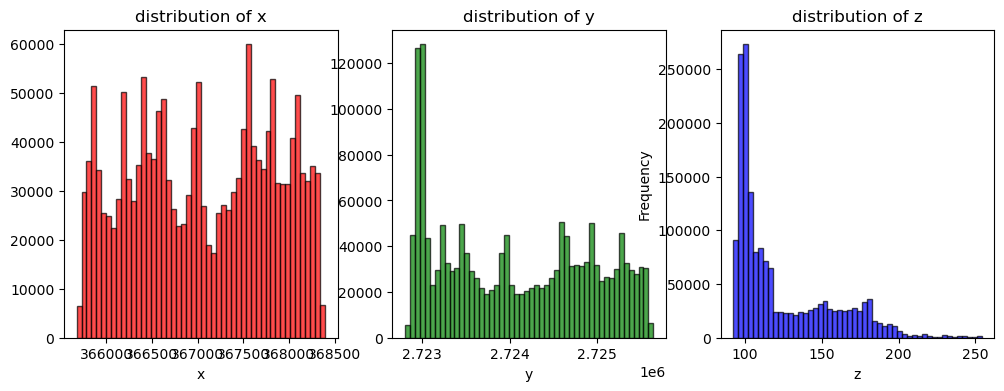

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(voxels[:, 0], bins=50, color="red", edgecolor='black', alpha=0.7)
plt.title('distribution of x')
plt.xlabel('x')

plt.subplot(1, 3, 2)
plt.hist(voxels[:, 1], bins=50, color="green", edgecolor='black', alpha=0.7)
plt.title('distribution of y')
plt.xlabel('y')

plt.subplot(1, 3, 3)
plt.hist(voxels[:, 2], bins=50, color="blue", edgecolor='black', alpha=0.7)
plt.title('distribution of z')
plt.xlabel('z')

plt.ylabel('Frequency')
# Display the histogram
plt.show()

In [22]:
heights = voxels[:, 2]
avg_height_curr = np.mean(heights)
avg_height_next = (np.mean(heights[heights < avg_height_curr]) + np.mean(heights[heights > avg_height_curr] )) / 2
print(f"average height before iteration: {avg_height_curr}")
while True:
    if abs(avg_height_next - avg_height_curr) < 1e-2:
        break
    avg_height_curr = avg_height_next
    avg_height_next = (np.mean(heights[heights < avg_height_curr]) + np.mean(heights[heights > avg_height_curr] )) / 2
print(f"average height after iteration: {avg_height_curr}")



average height before iteration: 123.90054725643047
average height after iteration: 136.93270321243529


In [23]:
selection = heights > avg_height_curr
print(f"retain rate: {np.sum(selection.astype(float)) / heights.size}")

filtered_voxels = voxels[selection]
filtered_colors = colors[idx_o2n][selection]

npy_to_ply(filtered_voxels, filtered_colors, "./filtererd_sample.ply")

retain rate: 0.29297941718922904
